# Multi-Scale Pyramids

This notebook is based on an assignment written by Ben Feinstein and Shira Kritchman.

## Introduction

In this notebook we will implement image pyramids, and get some first-hand experience with two of their applications:
* **Image focusing:** Using two or more images taken with different planes of focus in order to get a multi-focus image.
* **Image mosaicing:** Stitching images together in a visually-appealing way.

In [25]:
from collections import namedtuple

import numpy as np
from scipy.ndimage import convolve
# import ipywidgets as widgets
import skimage.color
from PIL import Image
# from IPython.display import display, Markdown
from pathlib import Path
import matplotlib.pyplot as plt

# from utils import imread, imwrite as _imwrite, imshow as _imshow, rgb2grey

# Conversion function

The following `safe_normalize()` function is given image and bounds (the expected `min` and `max` values), and normalizes it to integers (`np.uint8`) in the range `[0, 255]`. Out-of-bound values are rounded to the nearest value in `bounds`.

In [26]:
def safe_normalize(image, bounds=(0, 1)):
    """Receives a `image` represented by float numbers, with given range `bounds`, and convert it to `uint8`.

    Args:
        image (np.ndarray): the image.
        bounds (Tuple[float, float]): tuple of `(minval, maxval)`,  minimum and maximum values of image.
    
    Returns:
        np.ndarray: return the normalized image, with `dtype=np.uint8`.

    """
    npArrImg=np.array(image)
    maxBound=bounds[1]
    minBound=bounds[0]
    npArrImg[npArrImg>maxBound]=maxBound
    npArrImg[npArrImg<minBound]=minBound
    imageZeroBottom=npArrImg-minBound
    newMaxBound=maxBound-minBound
    imageRightTop=imageZeroBottom*(255/newMaxBound)
    return np.uint8(imageRightTop)

We also define other helper functions for I/O and automatic normalization.

In [42]:
def imwrite(path, image, bounds=(0, 1), **kwargs):
    """Normalize `image` and save it to `path`."""
    image = safe_normalize(image, bounds)
    Path("/my/directory").parents[0].mkdir(parents=True, exist_ok=True)
#     if not os.path.exists(os.path.dirname(path)):
#         os.makedirs(os.path.dirname(path))
    Image.fromarray(image).save(path)

def imread(path):
    image = Image.open(path).convert(mode='RGB')
    image = np.array(image).astype(np.float32) / 255
    return image

def imshow(image, bounds=(0, 1), title=None):
    """Normalize `image` and show it."""
    image = safe_normalize(image, bounds)
    plt.imshow(image)
    if title:
        plt.title(title)
#     display(Image.fromarray(image))
#     return _imshow(image, **kwargs)


def imshow_tabs(images, titles, figsize=(8, 6)):
    """Normalize `images`, and show them in tabs with the given tab names."""
    assert len(images) == len(titles)
    f, axarr = plt.subplots(1,len(images), figsize=figsize)
    for i, (image, name) in enumerate(zip(images,titles)):
        image = safe_normalize(images[i])
        axarr[i].imshow(image)
        axarr[i].set_title(titles[i])
        axarr[i].axes.get_xaxis().set_visible(False)
        axarr[i].axes.get_yaxis().set_visible(False)

# def imshow_hbox(images, titles=None, kwargs=None):
#     """Normalize `images`, and show them side-by-side."""
#     if kwargs is None:
#         kwargs = {}
#     if not isinstance(titles, (list, tuple)):
#         titles = [titles] * len(images)
#     assert len(images) == len(titles)

#     n = len(images)
#     if isinstance(kwargs, dict):
#         kwargs = [kwargs for _ in range(n)]
#     outputs = [widgets.Output() for _ in range(n)]
#     boxes = widgets.HBox(children=outputs)
#     for i, (output, image, title, kw) in enumerate(zip(outputs, images, titles, kwargs)):
#         with output:
#             imshow(image, title=title, **kw)
    
#     display(boxes)
    
# def imshow_vbox(images, titles=None, kwargs=None):
#     """Normalize `images`, and show them side-by-side."""
#     if kwargs is None:
#         kwargs = {}
#     if not isinstance(titles, (list, tuple)):
#         titles = [titles] * len(images)
#     assert len(images) == len(titles)

#     n = len(images)
#     if isinstance(kwargs, dict):
#         kwargs = [kwargs for _ in range(n)]
#     outputs = [widgets.Output() for _ in range(n)]
#     boxes = widgets.VBox(children=outputs)
#     for i, (output, image, title, kw) in enumerate(zip(outputs, images, titles, kwargs)):
#         with output:
#             imshow(image, title=title, **kw)
    
#     display(boxes)

def rgb2grey(images):
    return skimage.color.rgb2grey(images)

A simple demonstration:

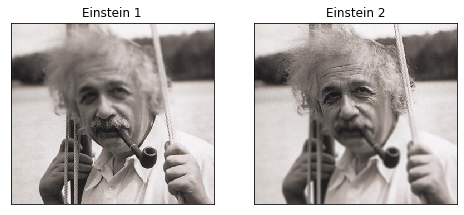

In [43]:
img1 = imread('data/focus/einstein1.png')
img2 = imread('data/focus/einstein2.png')
imshow_tabs([img1, img2], ['Einstein 1','Einstein 2'])

#  Image Pyramids

We will now implement basic image pyramid functions, following the paper ["The Laplacian Pyramid as a Compact Image Code"](https://ieeexplore.ieee.org/document/1095851) by Burt and Adelson, 1983. 

All of the tests will be run with the following parameters:

In [31]:
depth = 5
a = 0.375

## Gaussian Pyramids

### Generating Kernel

The following function creates the *Generating Kernel* depending on the parameter `a` (see page 533 in the paper).

In [32]:
def pyramid_kernel(a):
    """Returns the 5-by-5 generating kernel, given parameter `a`.
    
    Args:
        a (float): the kernel parameter.
    
    Returns:
        np.ndarray: 5-by-5 generating kernel.
    """

    vLen=5
    baseVec=np.array([0.25-0.5*a,0.25,a,0.25,0.25-0.5*a])
    transVec=np.transpose(baseVec)
    matForm=np.outer(baseVec,transVec)
    return matForm

We can test the function with a known sample kernel:

In [33]:
KERNEL_0375 = np.array([[1,  4,  6,  4, 1],
                        [4, 16, 24, 16, 4],
                        [6, 24, 36, 24, 6],
                        [4, 16, 24, 16, 4],
                        [1,  4,  6,  4, 1]]) / 256.0

np.testing.assert_array_equal(pyramid_kernel(a=0.375), KERNEL_0375)

### REDUCE
We will now implement the steps named *REDUCE* and *EXPAND* in the paper (pages 533-534).

We will need a function to perform 2D convolution:

In [34]:
def conv2d(image, kernel):
    """Convolves image with 2D kernel.
    
    Args:
        image (np.ndarray): base image.
        kernel (np.ndarray): kernel to convolve with `image`.
    
    Returns:
        np.ndarray: `image` convolved with `kernel`.
    """

    if image.ndim == 3 and kernel.ndim == 2:
        kernel = np.expand_dims(kernel, -1)
    
    return convolve(image, kernel, mode='mirror')

The REDUCE step:

In [35]:
def pyramid_reduce(image, kernel):
    """Reduces an image given a kernel.
    
    See:
        "The Laplacian Pyramid as a Compact Image Code" by Burt & Adelson (1983)
    
    Args:
        image (np.ndarray): image to reduce, of size (2*h, 2*w).
        kernel (np.ndarray): kernel to use for the reduction (usually 5x5).
    
    Returns:
        np.ndarray: reduced image, of size (h, w).
    """
    convedG0=conv2d(image,kernel)
    ndX,ndY=image.shape[0:2]
    idx=np.arange(0,ndX,2)
    idy=np.arange(0,ndY,2)
    vy,vx=np.meshgrid(idy,idx)
    downSampled=convedG0[vx,vy]
    return downSampled

The EXPAND step:

In [36]:
def pyramid_expand(image, kernel, out_size=None):
    """Expands an image given a kernel.
        
    Args:
        image (np.ndarray): image to expand, of size (h, w).
        kernel (np.ndarray): kernel to use for the expansion (usually 5x5).
        out_size (Tuple[int, int], optional): the expected shape of the returned image.
        
    Returns:
        np.ndarray: expanded image, of size (2*h, 2*w).
    """
    h, w, *c = image.shape
    outh, outw = (2 * h, 2 * w) if out_size is None else out_size
    assert abs(outh - 2 * h) <= 1 and abs(outw - 2 * w) <= 1, "`out_size` should be close to `(2*h, 2*w)`."
    new_image = np.zeros((outh, outw, *c))    
    new_image[::2, ::2, ...] = image
    return conv2d(new_image, 4 * kernel)

### Create a Gaussian pyramid

The following function creates a Gaussian pyramid using the previous functions:

In [37]:
def gaussian_reduce(image, kernel, depth):
    """Generates a Gaussian Pyramid from `image`, using `kernel` for reduction.
    
    The pyramid includes the original image (level 0), followed by `depth` reductions.
    
    Args:
        image (np.ndarray): image to reduce.
        kernel (np.ndarray): kernel to use for the reduction (usually 5x5).
        depth (int): how many reductions to apply.
    
    Returns:
        List[np.ndarray]: List of `depth + 1` pyramid levels, where the first level is the original image.
    """
    idx,idy=image.shape[0:2]
    outList=[image]
    currImage=image
    for i in range(depth):
        newLevel=pyramid_reduce(currImage,kernel)
        idx,idy=newLevel.shape[0:2]
        
        #outList.append(newLevel[0:(idx-idx%2),0:(idy-idy%2),:])
        outList.append(newLevel)
        currImage=newLevel
    return outList
    raise NotImplementedError()

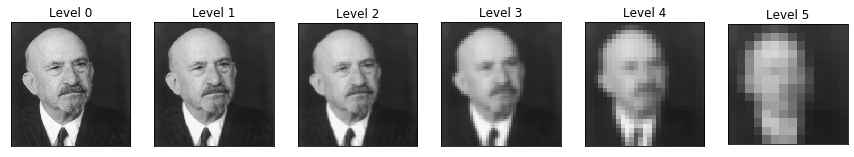

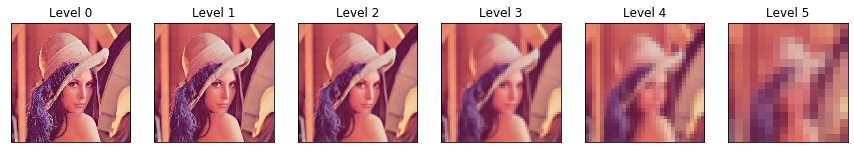

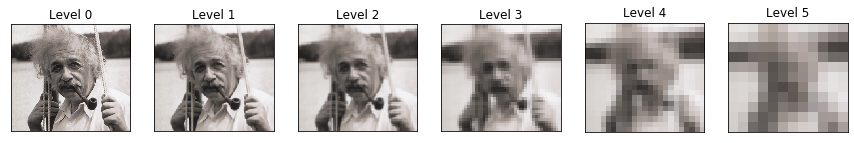

In [47]:
GaussianPyramidExample = namedtuple('GaussianPyramidExample', 'name path')
test_examples = [
    GaussianPyramidExample('Weizmann', 'data/pyramids/weizmann.png'),
    GaussianPyramidExample('Lenna', 'data/pyramids/lenna.png'),
    GaussianPyramidExample('Einstein', 'data/pyramids/einstein.png'),
]
# examples_outputs = widgets.Accordion(children=[widgets.Output() for _ in range(len(test_examples))])

kernel = pyramid_kernel(a)
for i, example in enumerate(test_examples):
    # set example name
#     examples_outputs.set_title(i, example.name)
    
    # plot inside example's area
#     with examples_outputs.children[i]:
    im = imread(example.path)
    pyramid = gaussian_reduce(im, kernel, depth=depth)
    titles = ['Level %d' % i for i in range(len(pyramid))]
    imshow_tabs(pyramid, titles=titles, figsize = (15,10))
#     plt.title(example.name)

## Laplacian Pyramids



### Laplacian reduction

The following function generates a Laplacian pyramid using the previous functions:

In [48]:
def laplacian_reduce(image, kernel, depth):
    """Generates a Laplacian Pyramid from `image`, using `kernel` for reduction.
    
    Args:
        image (np.ndarray): image to reduce.
        kernel (np.ndarray): kernel to use for the reduction (usually 5x5).
        depth (int): how many reductions to apply.
    
    Returns:
        List[np.ndarray]: List of `depth + 1` pyramid levels.
    """
    gaussPyramid=gaussian_reduce(image,kernel,depth)
    outList=[]
    for i in range(depth):
        gi=gaussPyramid[i]
        giP1=gaussPyramid[i+1]
        expMat=pyramid_expand(giP1,kernel,out_size=tuple(gi.shape[:2]))
        Li=gi-expMat
        
        outList.append(Li)
    outList.append(gaussPyramid[depth])
    return outList

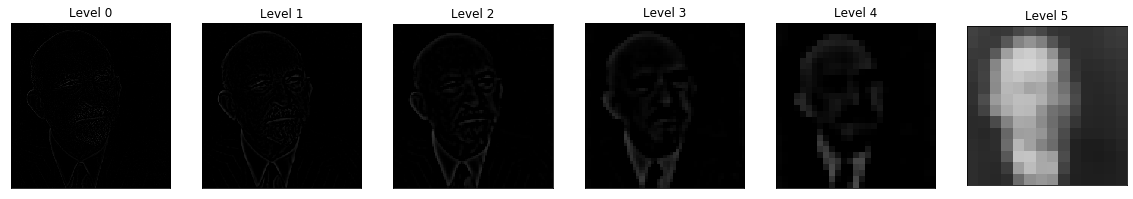

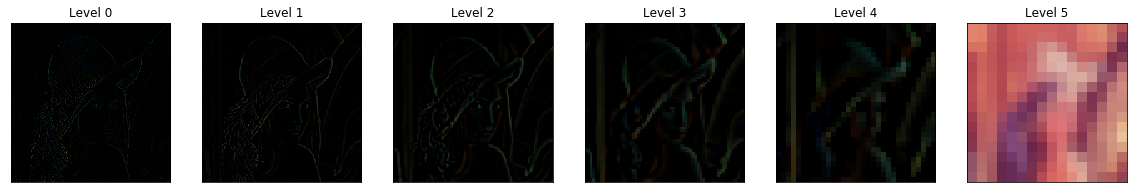

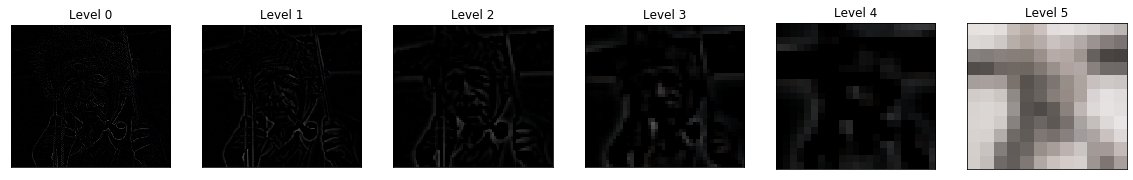

In [50]:
LaplacianPyramidExample = namedtuple('LaplacianPyramidExample', 'name path')
test_examples = [
    LaplacianPyramidExample('Weizmann', 'data/pyramids/weizmann.png'),
    LaplacianPyramidExample('Lenna', 'data/pyramids/lenna.png'),
    LaplacianPyramidExample('Einstein', 'data/pyramids/einstein.png'),
]
# examples_outputs = widgets.Accordion(children=[widgets.Output() for _ in range(len(test_examples))])

kernel = pyramid_kernel(a)
for i, example in enumerate(test_examples):
    # set example name
#     examples_outputs.set_title(i, example.name)
    
    # plot inside example's area
#     with examples_outputs.children[i]:
    im = imread(example.path)
    pyramid = laplacian_reduce(im, kernel, depth=depth)
    titles = ['Level %d' % i for i in range(len(pyramid))]
    kwargs = ([{'bounds': (-1, 1)} for _ in range(len(pyramid) - 1)] +  # bounds of laplacian layer
              [{'bounds': (0, 1)}])                                     # bounds of gaussian layer
    
    imshow_tabs(pyramid, titles=titles, figsize = (20,15))
#     imshow_vbox(pyramid, titles=titles, kwargs=kwargs)
        
# display(examples_outputs)

### Laplacian expansion

The following function reconstructs an image from a Laplacian pyramid:

In [51]:
def laplacian_expand(pyramid, kernel):
    """Reconstructs an image from a Laplacian Pyramid.
    
    Args:
        pyramid (List[np.ndarray]): list of `depth + 1` pyramid levels.
        kernel (np.ndarray): kernel that was used to create `pyramid`.
    
    Returns:
        np.ndarray: reconstructed image.
    """
    gi=pyramid[-1]
    for Li in reversed(pyramid[:-1]):
        giP1=gi
        gi=Li+pyramid_expand(giP1,kernel,tuple(Li.shape[0:2]))
    return gi

### Test : reduce then expand

We make sure that the reconstruced image is identical to the original image.

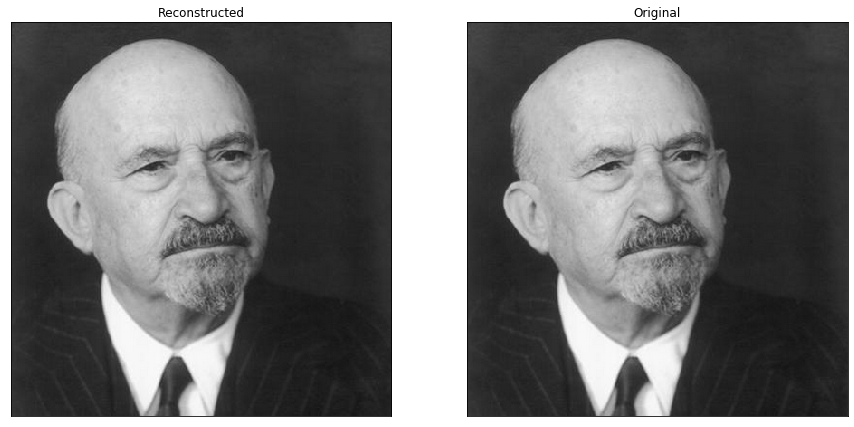

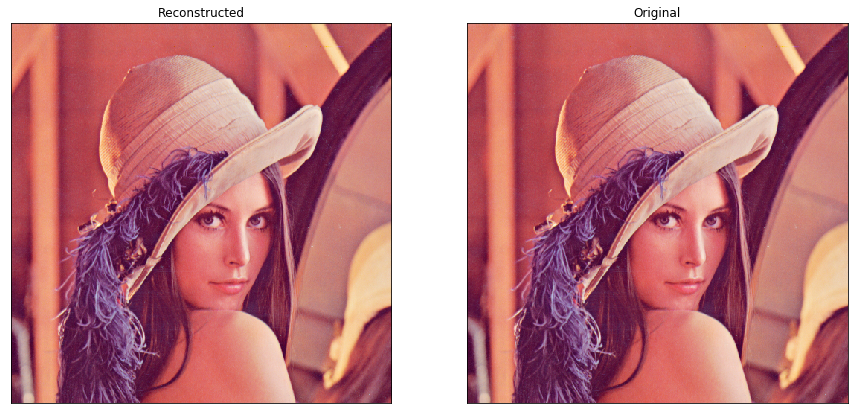

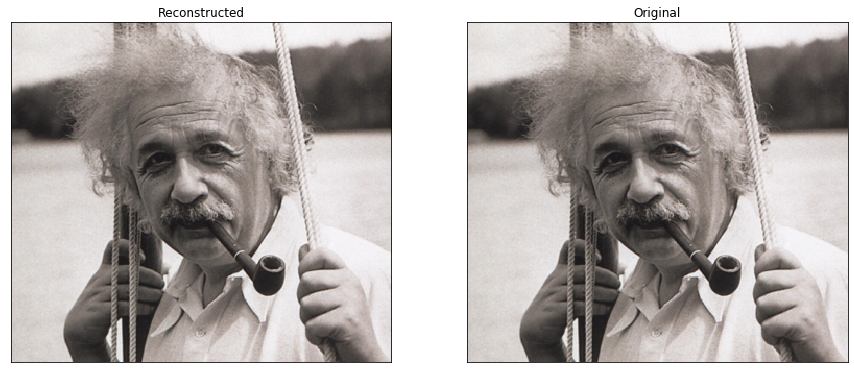

In [54]:
LaplacianExpandExample = namedtuple('LaplacianExpandExample', 'name path')
test_examples = [
    LaplacianExpandExample('Weizmann', 'data/pyramids/weizmann.png'),
    LaplacianExpandExample('Lenna', 'data/pyramids/lenna.png'),
    LaplacianExpandExample('Einstein', 'data/pyramids/einstein.png'),
]
# examples_outputs = widgets.Accordion(children=[widgets.Output() for _ in range(len(test_examples))])

kernel = pyramid_kernel(a)
for i, example in enumerate(test_examples):
    # set example name
#     examples_outputs.set_title(i, example.name)
    
    # plot inside example's area
#     with examples_outputs.children[i]:
    image = imread(example.path)
    pyramid = laplacian_reduce(image, kernel, depth=depth)
    expanded = laplacian_expand(pyramid, kernel)
#     imshow_tabs([expanded, image], tab_names=['Reconstructed', 'Original'])
    imshow_tabs([expanded, image], titles=['Reconstructed', 'Original'], figsize = (15,10))
        

# display(examples_outputs)

#  Applications

## Image Focusing
In this section we take two pictures that were shot with different focal planes and use them to generate a multi-focus image. It is based on the paper ["Pyramid Methods in Image Processing"](https://galerie-photo.com/images/pyramid-methods.pdf) by Burt, Adelson et al. (1984)  (page 38, blue box).

Differently focused photographies of the same object basically apply a blur (LP) filter to different zones of the same image. To reconstruct the unblurred image, we isolate the high frequencies pixels in each input image, which were affected (or not) by the "unfocus blur" and for each high-frequency pixel we choose the largest, i.e. the most unblurred pixel. Thus we select the unblurred areas from each image and compose a focused image as a whole. 

**Note:** The article addresses gray level images. When focusing RGB images, the correct way is to determine the maximum by the intensity image i.e. use `rgb2grey()` of the image (The final result should be in RGB).


The following function receives two unfocused images and combine them into a single focused image. The result should match the focused parts of the given images. 

**Note:** The correct way to combine the coarsest level (the "gaussian" level) of the two pyramids is to *average* them, and not to handle them as the finer ("laplacian") levels.

In [55]:
def image_focus(im1, im2, depth, a):
    """Generates a focused image from two unfocused images.
    
    Argls:
        im1 (np.ndarray): unfocused image #1.
        im2 (np.ndarray): unfocused image #2.
        depth (int): depth of pyramids to use.
        a (float): kernel parameter.
    
    Returns:
        np.ndarray: a focused image.
    """
    kernel=pyramid_kernel(a)
    lapPyramid1=laplacian_reduce(im1,kernel,depth)
    lapPyramid2=laplacian_reduce(im2,kernel,depth)
    revLapPyr1=list(reversed(lapPyramid1))
    revLapPyr2=list(reversed(lapPyramid2))
    combPyramid=[0.5*(revLapPyr1[0]+revLapPyr2[0])]
    for i in range(1,depth+1):
        currLvl1=revLapPyr1[i]
        grey1=rgb2grey(currLvl1)
        currLvl2=revLapPyr2[i]
        grey2=rgb2grey(currLvl2)
        cImg=np.zeros_like(currLvl1)
        for inds,x in np.ndenumerate(grey1):
            if abs(grey1[inds])>=abs(grey2[inds]):
                newPixels=currLvl1[inds[0],inds[1],[0,1,2]]
            else:
                newPixels=currLvl2[inds[0],inds[1],[0,1,2]]
            cImg[inds[0],inds[1],[0,1,2]]=newPixels
        combPyramid.append(cImg)
    combPyramidInOrder=list(reversed(combPyramid))
    resImg=laplacian_expand(combPyramidInOrder,kernel)
    return resImg

### 2.1.3 Test your method: `image_focus()`

Run the following tests and make sure that `image_focus()` works well.

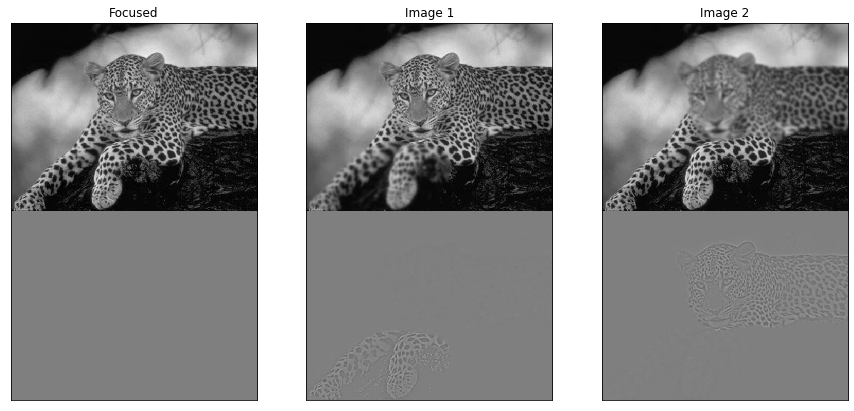

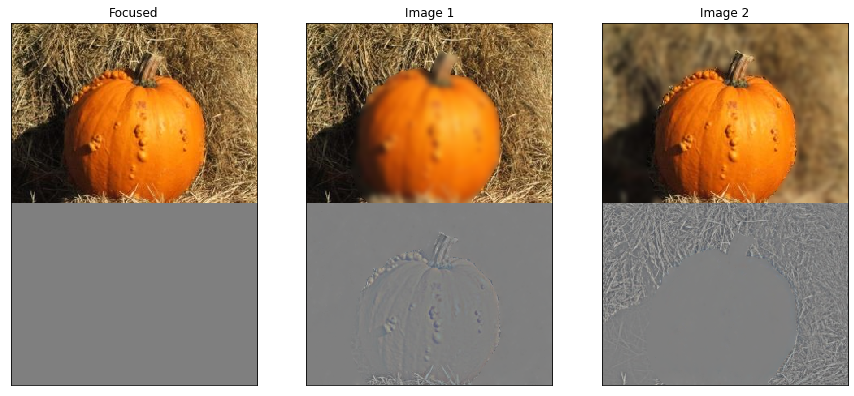

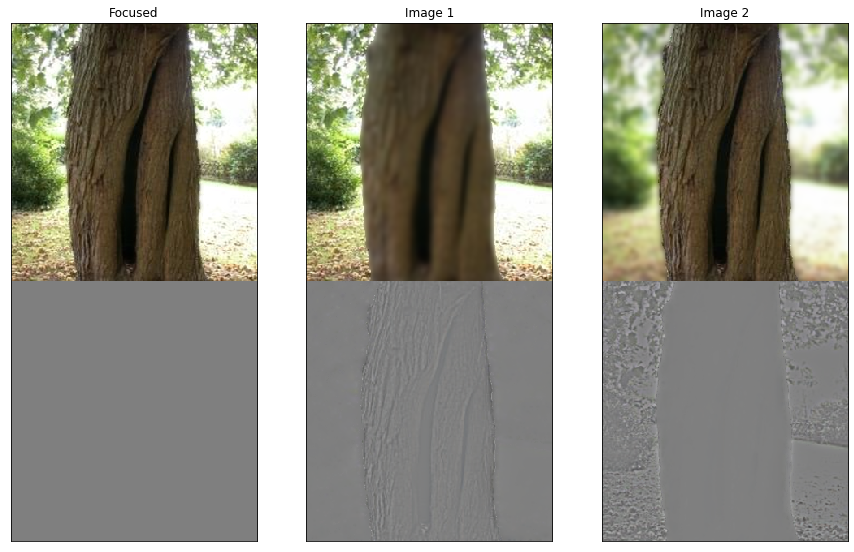

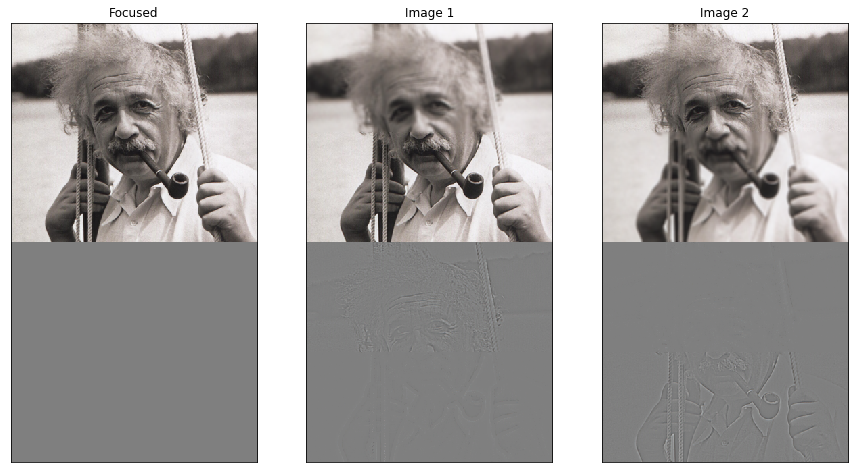

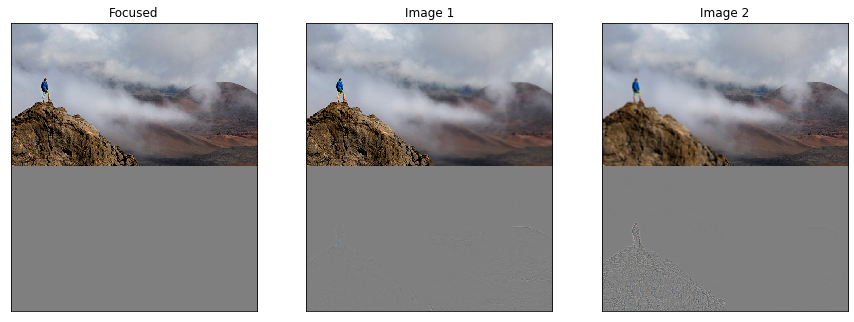

In [58]:
FocusExample = namedtuple('FocusExample', 'name path1 path2')
test_examples = [
    FocusExample('Leopard', 'data/focus/leopard1.bmp', 'data/focus/leopard2.bmp'),
    FocusExample('Pumpkin', 'data/focus/pumpkin1.png', 'data/focus/pumpkin2.png'),
    FocusExample('Tree', 'data/focus/tree1.png', 'data/focus/tree2.png'),
    FocusExample('Einstein', 'data/focus/einstein1.png', 'data/focus/einstein2.png'),
    FocusExample('Mountain', 'data/focus/mountain1.png', 'data/focus/mountain2.png'),
]
# examples_outputs = widgets.Accordion(children=[widgets.Output() for _ in range(len(test_examples))])

kernel = pyramid_kernel(a)
for i, example in enumerate(test_examples):
    # set example name
#     examples_outputs.set_title(i, example.name)
    
#     # plot inside example's area
#     with examples_outputs.children[i]:
    im1 = imread(example.path1)
    im2 = imread(example.path2)
    focused = image_focus(im1, im2, depth=depth, a=a)
    images = [np.vstack([img, (focused - img) / 2 + 0.5]) for img in [focused, im1, im2]]
    tab_names = ['Focused', 'Image 1', 'Image 2']
#         imshow_tabs(images, tab_names, titles='`image` (top), `focused - image` (bottom)')
    imshow_tabs(images, titles=['Focused', 'Image 1', 'Image 2'], figsize = (15,10))

# display(examples_outputs)

### Multiple image focusing

We now try to generalize the algorithm for image focusing to  *multiple* (more than 2) unfocused images, and combine them into a single focused image.

In [61]:
def image_multi_focus(images, depth, a):
    """Generates a focused image from multiple unfocused images.
    
    Args:
        images (List[np.ndarray]): list of unfocused images.
        depth (int): depth of pyramids to use.
        a (float): kernel parameter.
    
    Returns:
        np.ndarray: a focused image.
    """
    kImgs=len(images)
    kernel=pyramid_kernel(a)
    lapPyrsRev=[]
    for image in images:
        lapPyrsRev.append(list(reversed(laplacian_reduce(image,kernel,depth))))
    baseImg=np.zeros_like(lapPyrsRev[0][0])
    for i in range(kImgs): #Easier just to split the loop in two than initializing baseImg somehow
        gaussImg=lapPyrsRev[i][0]
        baseImg+=gaussImg
    baseImg=baseImg/kImgs
    outPyr=[baseImg]
    for currLvl in range(1,depth+1):
        firstImage=rgb2grey(lapPyrsRev[0][currLvl])
        greyImgsAbs=np.zeros((firstImage.shape[0],firstImage.shape[1],kImgs))
        cImg=np.zeros_like(lapPyrsRev[0][currLvl])
        for j in range(kImgs):
            greyImg=rgb2grey(lapPyrsRev[j][currLvl])
            greyImgsAbs[:,:,j] = greyImg
        #print(greyImgsAbs.shape)
        for inds,x in np.ndenumerate(firstImage):
            all_pixels = greyImgsAbs[inds[0],inds[1],:]
            all_pixels_abs = np.abs(all_pixels)
            indMax=np.argmax(all_pixels_abs)
            chosenPyr=lapPyrsRev[indMax]
            newPixels=chosenPyr[currLvl][inds[0],inds[1]]
            cImg[inds[0],inds[1],[0,1,2]]=newPixels
        outPyr.append(cImg)
    combPyrInOrder=list(reversed(outPyr))
    resImg=laplacian_expand(combPyrInOrder,kernel)
    return resImg

### Test

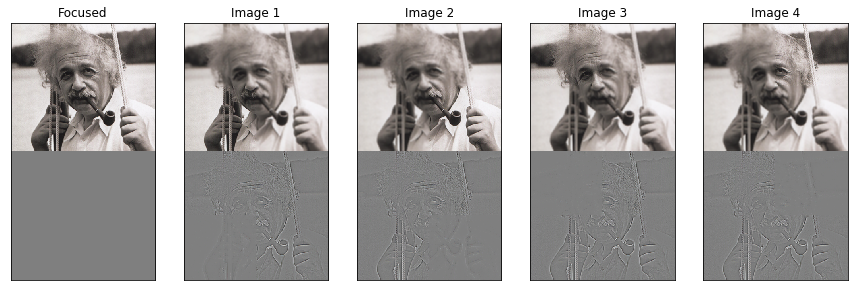

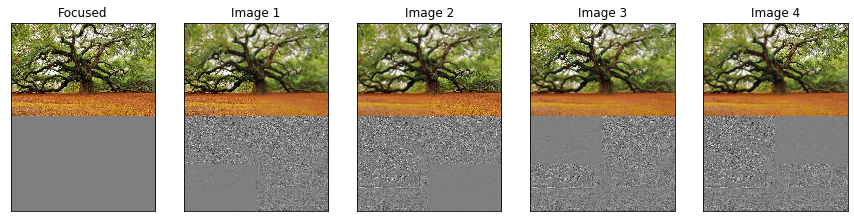

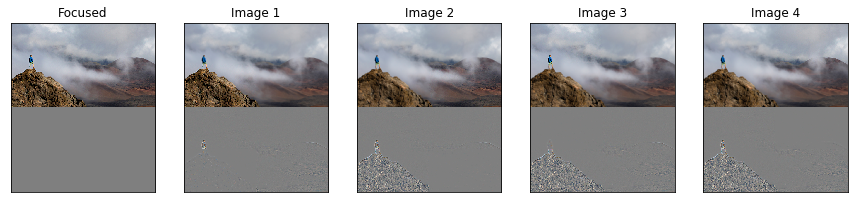

In [67]:
MultiFocusExample = namedtuple('MultiFocusExample', 'name paths')
test_examples = [
    MultiFocusExample('Einsten', ['data/multi_focus/einstein%d.png' % (i + 1) for i in range(4)]),
    MultiFocusExample('Tree', ['data/multi_focus/tree%d.png' % (i + 1) for i in range(4)]),
    MultiFocusExample('Mountain', ['data/multi_focus/mountain%d.png' % (i + 1) for i in range(4)]),
]
# examples_outputs = widgets.Accordion(children=[widgets.Output() for _ in range(len(test_examples))])

kernel = pyramid_kernel(a)
for i, example in enumerate(test_examples):
    # set example name
#         examples_outputs.set_title(i, example.name)

    # plot inside example's area
#         with examples_outputs.children[i]:
    imgs = [imread(path) for path in example.paths]
    focused = image_multi_focus(imgs, depth=depth, a=a)
    images = [np.vstack([img, focused - img + 0.5]) for img in [focused] + imgs]
    tab_names = ['Focused'] + ['Image %d' % (i + 1) for i in range(len(imgs))]
    imshow_tabs(images, titles=tab_names, figsize = (15,10))

## Image Mosaicing
We can also stitch images together in a visually-appealing way if we make the transition separately at each level of the Laplacian pyramid. This section is based on pages 39-40 (green boxes) of the article "Pyramid Methods in Image Processing" (which was already linked above).

This kind of transition works better than simple smoothing because the smoothing (i.e. some kind of LPF), if too narrow or too wide, will not give a natural transition. Intuitively, if the images were only composed of low frequencies (e.g. different uniform colors), a wide transition is needed so that the color gradient at the boundary will be smooth enough - a narrow transition will still leave a somewhat blurred unnatural edge. The reverse is true for high frequencies, which need a narrower smooth transition.

Thus, applying the same smoothing transition for all frequencies will (in general) not give natural-looking results, as some changes at some frequencies won't be smoothed well.

The solution is to vary the width of the smoothing transition depending on the frequency. This is implemented by the equivalent weighting functions of the Laplacian pyramid, which smooth every frequency differently.

The following function gets two images `im1` and `im2`, and a 2D mask `mask` (with values between 0 to 1) and stitches the images, according to the mask.

**Note:** The article uses a binary mask in order to choose the value at each point in the pyramid. However, in order to avoid sharp transitions and get appealing results, we need to smooth the mask a bit at each pyramid level. Smooth the `mask` with `5x5` uniform filter before downscaling it.

In [69]:
def image_mosaic(im1, im2, mask, depth, a):
    """Stiches two images together.
    
    Args:
        im1 (np.ndarray): first image to stich (where `mask=0`).
        im2 (np.ndarray): second image to stich (where `mask=1`).
        mask (np.ndarray): mask to select what part to take from which image.
        depth (int): how many pyramid levels to use in for smooth result.
        a (float): kernel parameter.
    
    Returns:
        np.ndarray: stiched images according to mask.
    """
    kernel=pyramid_kernel(a)
    maskingKernel=1/25*np.ones((5,5))
    lapPyr1=laplacian_reduce(im1,kernel,depth)
    lapPyr2=laplacian_reduce(im2,kernel,depth)
    maskPyr=gaussian_reduce(mask,maskingKernel,depth) #We separate the mask itself to its pyramid for better results instead of manual downsampling!
    outPyr=[]
    for i in range(depth+1):
       # currMask=np.repeat(maskPyr[i],3,axis=2)
        currMask=maskPyr[i]
        cImg=currMask*lapPyr2[i]+(1-currMask)*lapPyr1[i]
        outPyr.append(cImg)
    outPic=laplacian_expand(outPyr,kernel)
    return outPic

Demonstration:

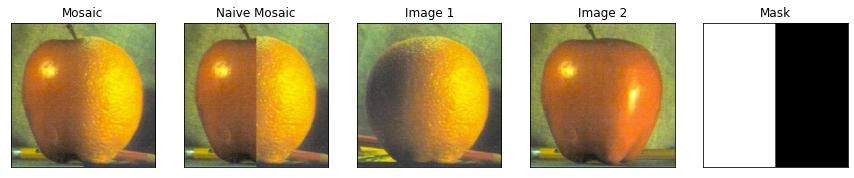

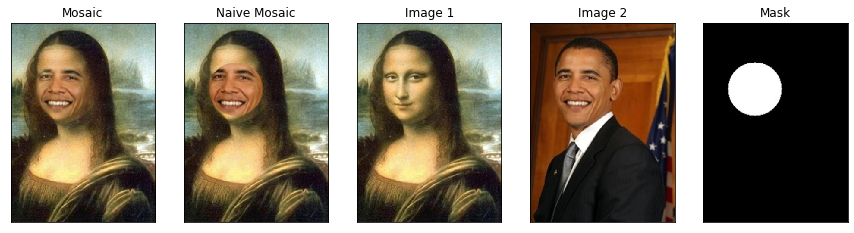

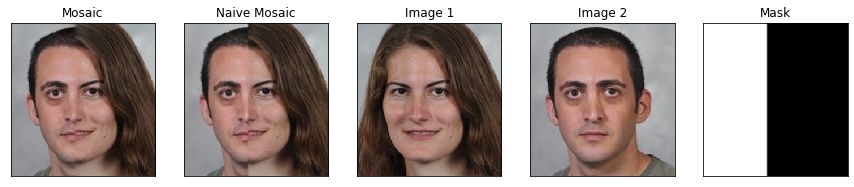

In [70]:
MosaicExample = namedtuple('MultiFocusExample', 'name path1 path2 path_mask')
test_examples = [
    MosaicExample('Orange + Apple',
                  'data/mosaic/orange_apple/orange.jpg',
                  'data/mosaic/orange_apple/apple.jpg',
                  'data/mosaic/orange_apple/orangapple_m.bmp'),
    MosaicExample('Monalisa + Obama',
                  'data/mosaic/monalisa_obama/monalisa.jpg',
                  'data/mosaic/monalisa_obama/obama.jpg',
                  'data/mosaic/monalisa_obama/monobama_m.jpg'),
    MosaicExample('Michal + Tal',
                  'data/mosaic/michal_tal/michal.bmp',
                  'data/mosaic/michal_tal/tal.bmp',
                  'data/mosaic/michal_tal/michtal_m.bmp'),
]
# examples_outputs = widgets.Accordion(children=[widgets.Output() for _ in range(len(test_examples))])

kernel = pyramid_kernel(a)
for i, example in enumerate(test_examples):
    # set example name
#     examples_outputs.set_title(i, example.name)
    
    # plot inside example's area
#     with examples_outputs.children[i]:
        im1 = imread(example.path1)
        im2 = imread(example.path2)
        mask = imread(example.path_mask)
        mosaic_naive = image_mosaic(im1, im2, mask, depth=0, a=a)
        mosaic = image_mosaic(im1, im2, mask, depth=depth, a=a)
        images = [mosaic, mosaic_naive, im1, im2, mask]
        tab_names = ['Mosaic', 'Naive Mosaic', 'Image 1', 'Image 2', 'Mask']
        imshow_tabs(images, titles= tab_names, figsize = (15,10))
        
# display(examples_outputs)